This notebook only makes a figure out of pre-computed behavior predictions.
It relies on finding a summary file in the `results` folder.

To recompute ad reproduce these results from scratch, one would need to run the following scripts:
1. `./scripts/chewie/extract_data.py` to save the ground truth data
2. `./scripts/chewie/run_biRNN_decoder.py` to save the results of the biRNN decoder 
3. `./scripts/chewie/run_avg_per_epoch.py` to save the trial-average per-condition predictions
4. `./scripts/chewie/run_PSID.py` to save the results of the PSID decoder
5. `./scripts/chewie/run_CEBRA.py` to save the results of the CEBRA decoder
6. Run LFADS/BAND training, ablate controls, run `scripts/band_performance.py` afterwards to save each run to a summary table (see `./scripts/run_sequence.py` as an example of all actions and naming that automatically goes into summary)

In [1]:
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from numpy.fft import fft, fftfreq

from plot_helpers import get_trials2plot, get_random_trials2plot, plot_fourier_last_sessions

from lfads_torch.metrics import r2_score, r2_UIVE

%load_ext nb_black

Matplotlib created a temporary cache directory at /tmp/matplotlib-eolc0uw3 because the default path (/afs/inf.ed.ac.uk/user/n/nkudryas/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<IPython.core.display.Javascript object>

In [2]:
experiments = [
   "Chewie_CO_FF_2016-09-15",
   "Chewie_CO_FF_2016-09-21",
   "Chewie_CO_FF_2016-10-05",
   "Chewie_CO_FF_2016-10-07",
   "Mihili_CO_FF_2014-02-03",
   "Mihili_CO_FF_2014-02-17",
   "Mihili_CO_FF_2014-02-18",
   "Mihili_CO_FF_2014-03-07",

]
data = {}
for experiment in tqdm(experiments):
   path = f'../../results/{experiment}.h5'
   data[experiment] = {}
   with h5py.File(path, 'r') as f:
      for key in f.keys():
         data[experiment][key] = f[key][()]
data.keys()

100%|██████████| 8/8 [00:00<00:00, 25.15it/s]


dict_keys(['Chewie_CO_FF_2016-09-15', 'Chewie_CO_FF_2016-09-21', 'Chewie_CO_FF_2016-10-05', 'Chewie_CO_FF_2016-10-07', 'Mihili_CO_FF_2014-02-03', 'Mihili_CO_FF_2014-02-17', 'Mihili_CO_FF_2014-02-18', 'Mihili_CO_FF_2014-03-07'])

<IPython.core.display.Javascript object>

In [3]:
dset='valid'
epoch_name = np.array(['BL','AD','WO'])
vel = {experiment: data[experiment][f'{dset}_behavior'][:] for experiment in experiments}
target_direction = {experiment: data[experiment][f'{dset}_target_direction'][:] for experiment in experiments}
epoch = {experiment: data[experiment][f'{dset}_epoch'][:] for experiment in experiments}
epoch_names = {experiment: epoch_name[data[experiment][f'{dset}_epoch'][:]] for experiment in experiments}
pos = {experiment: np.cumsum(vel[experiment], axis=1) for experiment in experiments}

<IPython.core.display.Javascript object>

# Get an avg per-epoch performance over sessions

In [7]:
key ='test_all_avg_per_epoch_pred'
r2s = []
for exp in experiments:
    epoch_mask, epoch_name = (epoch[exp]==0), 'BL'
    # epoch_mask, epoch_name = (epoch[exp]==1), 'AD'
    # epoch_mask, epoch_name = (epoch[exp]==2), 'WO'
    pred_vel = data[exp][key]
    r2 = r2_score(pred_vel[epoch_mask], vel[exp][epoch_mask])
    r2s.append(r2)
print(r2s)
print(np.mean(r2s), np.std(r2s))
# note, this is on validation set only!!!

[0.8993159755797393, 0.8764872683452888, 0.9082995802321518, 0.8462170983047688, 0.8281069272468169, 0.838500151846702, 0.8878443568587828, 0.8593872964783361]
0.8680198318615733 0.02757024513187826


<IPython.core.display.Javascript object>

In [11]:
100-83.5

16.5

<IPython.core.display.Javascript object>

# Continue to plots

In [4]:
dir_index = {experiment: np.array([
        sorted(set(target_direction[experiment])).index(i) for i in target_direction[experiment]
    ]) for experiment in experiments}

avg_vel_per_epoch = {experiment: data[experiment]['test_all_avg_per_epoch_pred'] for experiment in experiments}


<IPython.core.display.Javascript object>

In [5]:
experiment = experiments[4]
# np.array([get_random_trials2plot(dir_index[experiment], epoch[experiment], i) for i in range(3)]).sum(0)
dir_index[experiment]

array([2, 4, 0, 2, 4, 7, 1, 6, 3, 5, 3, 6, 2, 1, 6, 7, 2, 0, 5, 7, 7, 2,
       7, 1, 7, 7, 6, 2, 7, 3, 0, 0, 2, 7, 2, 4, 5, 1, 5, 5, 4, 4, 7, 4,
       0, 4, 6, 2, 7, 7, 6, 2, 2, 0, 0, 2, 7, 0, 1, 2, 0, 1, 0, 2, 2, 0,
       1, 2, 5, 2, 2, 0, 7, 7, 7, 0, 4, 3, 1, 0, 4, 6, 6, 0, 0, 1, 3, 4,
       6, 2, 3, 4, 4, 1, 0, 2, 0, 2, 0, 7, 2, 2, 6, 6, 0, 2, 1, 3, 6, 2,
       3, 5, 1, 4, 1, 4, 4, 3, 6, 3, 6])

<IPython.core.display.Javascript object>

In [6]:
np.random.seed(1)
# trials2plot = np.array([get_random_trials2plot(vel, avg_vel_per_epoch, dir_index, epoch, i) for i in range(3)]).sum(0)
trials2plot = {experiment: np.array([get_random_trials2plot(dir_index[experiment], epoch[experiment], i) for i in range(3)]).sum(0) for experiment in experiments}
trials2plot[experiments[0]].sum()

24

<IPython.core.display.Javascript object>

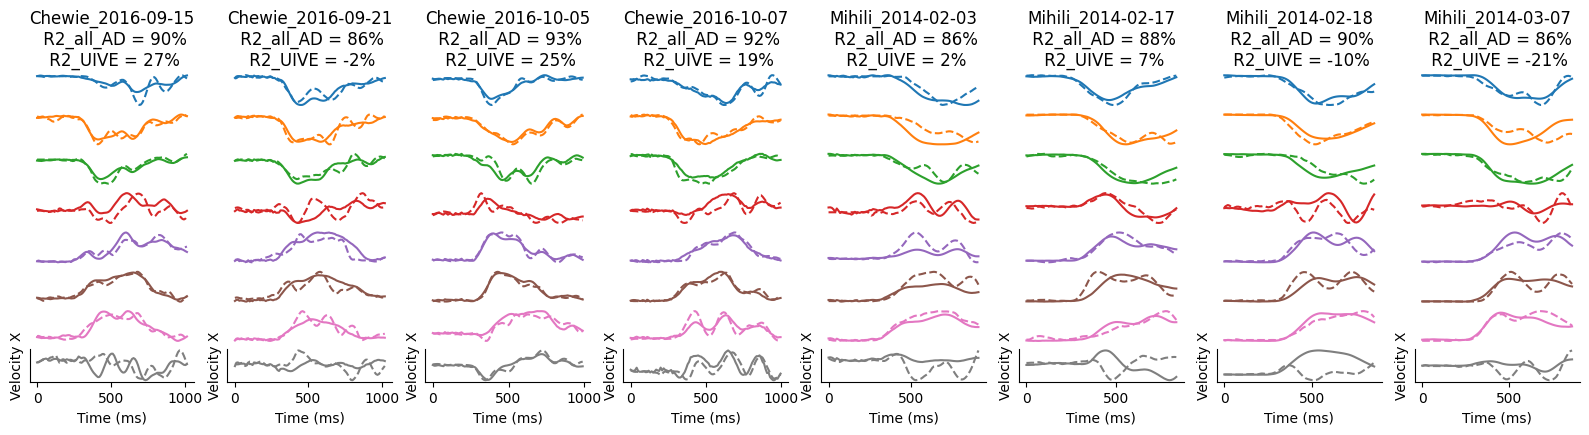

<IPython.core.display.Javascript object>

In [14]:
def plot_beh_pred(vel, pred_vel, dir_index, t2p, axes, area, epoch_name, component=0,title=""):
    '''
    Plot hand velocity and predicted hand velocity for each direction
    '''

    BIN_SIZE = 10 # ms
    time = np.arange(vel.shape[1]) * BIN_SIZE

    for v, ls in zip([vel, pred_vel], ["--", "solid"]):
        for t in range(0, vel.shape[0]):
            if t2p[t]:
                d = dir_index[t]
                axes[d].plot(
                    time,
                    v[t, :, component],
                    color=f"C{d}",
                    alpha=1,
                    ls=ls,
                )

    for ax in axes[:-1]:
        ax.axis("off")
    axes[-1].spines['top'].set_visible(False)
    axes[-1].spines['right'].set_visible(False)
    axes[-1].set_yticks([])
    axes[-1].set_xlabel("Time (ms)")
    axes[-1].set_ylabel("Velocity X")

    R2_iso_vel = r2_score(pred_vel,vel)
    R2_UIVE = r2_UIVE(pred_vel, vel, dir_index)

    axes[0].set_title(f'{title}\n R2_{area}_{epoch_name} = {R2_iso_vel*100:.0f}%\n R2_UIVE = {R2_UIVE*100:.0f}%')


        

fig, axes = plt.subplots(8,8,figsize=(8*2.5, 8*.5))


component = 0

area = 'all'
# key =f'test_{area}_birnn_pred'
# key =f'test_{area}_band_pred'
# key =f'test_{area}_lfads_100f_4c_pred'
key =f'test_{area}_band_100f_4c_pred'
for i, experiment in enumerate(experiments):

    # epoch_mask, epoch_name = (epoch[experiment]==0), 'BL'
    epoch_mask, epoch_name = (epoch[experiment]==1), 'AD'
    # epoch_mask, epoch_name = (epoch[experiment]==2), 'WO'

    title = experiment.split('_CO_FF')
    title = title[0] + title[1]

    plot_beh_pred(vel[experiment][epoch_mask], 
                data[experiment][key][epoch_mask], 
                dir_index[experiment][epoch_mask], 
                trials2plot[experiment][epoch_mask], 
                axes[:,i], 
                area,
                epoch_name,
                component=1, 
                title=title)

fig.savefig("figs/Figure4")

## biRNN across areas and monkeys

In [11]:
data[experiment].keys()

dict_keys(['test_M1_MUA_birnn_pred', 'test_M1_band_100f_4c_pred', 'test_M1_band_8f_4c_pred', 'test_M1_band_pred', 'test_M1_birnn_pred', 'test_M1_cebra_pred', 'test_M1_lfads_100f_4c_pred', 'test_M1_lfads_8f_4c_pred', 'test_M1_lfads_pred', 'test_M1_psid_pred', 'test_PMd_MUA_birnn_pred', 'test_PMd_band_100f_4c_pred', 'test_PMd_band_8f_4c_pred', 'test_PMd_band_pred', 'test_PMd_birnn_pred', 'test_PMd_cebra_pred', 'test_PMd_lfads_100f_4c_pred', 'test_PMd_lfads_8f_4c_pred', 'test_PMd_lfads_pred', 'test_PMd_psid_pred', 'test_all_MUA_birnn_pred', 'test_all_avg_per_epoch_pred', 'test_all_band_100f_4c_pred', 'test_all_band_8f_4c_pred', 'test_all_band_pred', 'test_all_birnn_pred', 'test_all_cebra_pred', 'test_all_lfads_100f_4c_pred', 'test_all_lfads_8f_4c_pred', 'test_all_lfads_pred', 'test_all_psid_pred', 'train_M1_MUA_birnn_pred', 'train_M1_band_100f_4c_pred', 'train_M1_band_8f_4c_pred', 'train_M1_band_pred', 'train_M1_birnn_pred', 'train_M1_cebra_pred', 'train_M1_lfads_100f_4c_pred', 'train_M1_

<IPython.core.display.Javascript object>

In [42]:
# fig, axes = plt.subplots((8+3)*3,8,figsize=(8*2.5, ((8+3)*3)*.5))

# component = 0

# for j, area in enumerate(['all', 'M1', 'PMd']):
#     # key =f'test_{area}_birnn_pred'
#     key =f'test_{area}_band_8f_4c_pred'
#     for i, experiment in enumerate(experiments):

#         # epoch_mask, epoch_name = (epoch[experiment]==0), 'BL'
#         epoch_mask, epoch_name = (epoch[experiment]==1), 'AD'
#         # epoch_mask, epoch_name = (epoch[experiment]==2), 'WO'

#         title = experiment.split('_CO_FF')
#         title = title[0] + title[1]

#         plot_beh_pred(vel[experiment][epoch_mask], 
#                     data[experiment][key][epoch_mask], 
#                     dir_index[experiment][epoch_mask], 
#                     trials2plot[experiment][epoch_mask], 
#                     axes[(8+3)*j:(8+3)*j+8,i], 
#                     area,
#                     epoch_name,
#                     component=1, 
#                     title=title)
        
#         axes[(8+3)*j + 8,i].axis("off")
#         axes[(8+3)*j + 9,i].axis("off")
#         axes[(8+3)*j + 10,i].axis("off")

#     ax = axes[(8+3)*j + 3,0]
#     ax.axis('on')
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.set_yticks([])
#     ax.set_xticks([])
#     ax.set_ylabel(area)

# fig.savefig("figs/Figure4")

<IPython.core.display.Javascript object>

In [43]:
data['Chewie_CO_FF_2016-09-15'].keys()

dict_keys(['test_M1_MUA_birnn_pred', 'test_M1_band_100f_4c_pred', 'test_M1_band_8f_4c_pred', 'test_M1_band_pred', 'test_M1_birnn_pred', 'test_M1_cebra_pred', 'test_M1_lfads_100f_4c_pred', 'test_M1_lfads_8f_4c_pred', 'test_M1_lfads_pred', 'test_M1_psid_pred', 'test_PMd_MUA_birnn_pred', 'test_PMd_band_100f_4c_pred', 'test_PMd_band_8f_4c_pred', 'test_PMd_band_pred', 'test_PMd_birnn_pred', 'test_PMd_cebra_pred', 'test_PMd_lfads_100f_4c_pred', 'test_PMd_lfads_8f_4c_pred', 'test_PMd_lfads_pred', 'test_PMd_psid_pred', 'test_all_MUA_birnn_pred', 'test_all_avg_per_epoch_pred', 'test_all_band_100f_4c_pred', 'test_all_band_8f_4c_pred', 'test_all_band_pred', 'test_all_birnn_pred', 'test_all_cebra_pred', 'test_all_lfads_100f_4c_pred', 'test_all_lfads_8f_4c_pred', 'test_all_lfads_pred', 'test_all_psid_pred', 'train_M1_MUA_birnn_pred', 'train_M1_band_100f_4c_pred', 'train_M1_band_8f_4c_pred', 'train_M1_band_pred', 'train_M1_birnn_pred', 'train_M1_cebra_pred', 'train_M1_lfads_100f_4c_pred', 'train_M1_

<IPython.core.display.Javascript object>

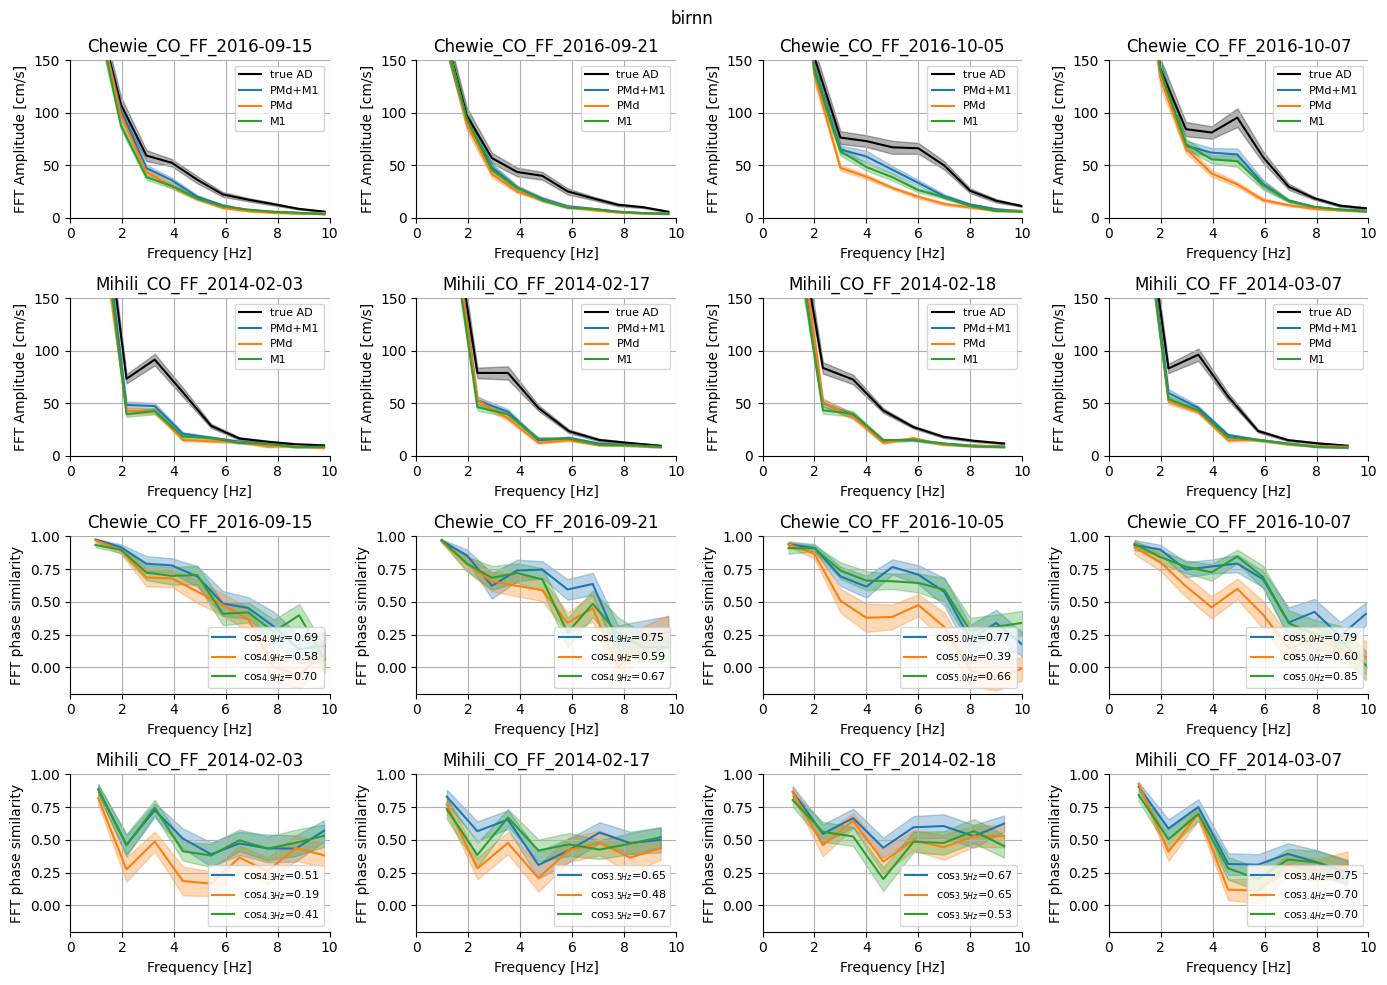

<IPython.core.display.Javascript object>

In [74]:
def plot_fourier(ax, ax_p, V, V_true, dt=0.01, label='', 
                 c='k', linestyle='solid', peak_freq = 5):
                #  text_pos = None):

        SR = []
        cos_sim = []
        for _ in range(100):

            idxs = np.random.choice(V.shape[0], V.shape[0], replace=True)

            x = V[idxs]
            xf = fft(x)  # Compute Fourier transform of x
            Sxx_all = (xf * xf.conj()).real # Compute power spectrum
            
            SR.append(np.sqrt(Sxx_all).mean(0))

            if V_true is not None:
                x_true = V_true[idxs]
                xf_true = fft(x_true)  # Compute Fourier transform of x_true
                cos = np.cos(np.angle(xf) - np.angle(xf_true))
                cos_sim.append(cos.mean(0))

        faxis = fftfreq(Sxx_all.shape[1]) / dt  # Construct frequency axis
        SR = np.asarray(SR) # [samples, freq]

        mask = (faxis > 0) & (faxis <= 10)
        ax.plot(
            faxis[mask],
            SR.mean(0)[mask],c=c, label=label, linestyle=linestyle)
        
        ax.fill_between(
            faxis[mask],
            SR.mean(0)[mask] - SR.std(0)[mask],
            SR.mean(0)[mask] + SR.std(0)[mask],
            alpha=0.3, color=c
        )

        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel(r'FFT Amplitude [cm/s]')
        ax.set_ylim([0,150])
        ax.set_xlim([0,10])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True)

        if V_true is not None:
            cos_sim = np.asarray(cos_sim) # [samples, freq]

            idx_peak = np.argmin(np.abs(faxis - peak_freq))
            str = 'cos$_{' + f'{faxis[idx_peak]:.1f}' +'Hz}$='
            label_p = rf'{str}' + f'{cos_sim.mean(0)[idx_peak]:.2f}'

            ax_p.plot(
                faxis[mask],
                cos_sim.mean(0)[mask],c=c, label=label_p, linestyle=linestyle)
            
            ax_p.fill_between(
                faxis[mask],
                cos_sim.mean(0)[mask] - cos_sim.std(0)[mask],
                cos_sim.mean(0)[mask] + cos_sim.std(0)[mask],
                alpha=0.3, color=c
            )
            ax_p.set_xlabel('Frequency [Hz]')
            ax_p.set_ylabel(r'FFT phase similarity')
            ax_p.set_ylim([-0.2,1])
            ax_p.set_xlim([0,10])
            ax_p.spines['top'].set_visible(False)
            ax_p.spines['right'].set_visible(False)
            ax_p.grid(True)

            # if text_pos is not None:
            #     idx_peak = np.argmin(np.abs(faxis - peak_freq))
            #     str = 'cos$_{' + f'{faxis[idx_peak]:.1f}' +'Hz}$='
            #     ax_p.text(text_pos[0], text_pos[1], 
            #               rf'{str}' + f'{cos_sim.mean(0)[idx_peak]:.2f}', fontsize=10, color=c)

# model = 'band_100f_4c'
# model = 'band_8f_4c'
model = 'birnn'
# model = 'lfads_100f_4c'
# model = 'psid'

component=0
fig, axes = plt.subplots(4,4,figsize=(14,10))
for ax, ax_p, exp in zip(axes[:2].flatten(),axes[2:].flatten(), experiments):
    plot_fourier(ax, ax_p, 
                 vel[exp][epoch[exp]==1][...,component], 
                 None,
                 label='true AD',c='k')
    # plot_fourier_AD(ax, vel[exp][epoch[exp]==0], 'true BL',color='k',linestyle=':')
    for i_a, area in enumerate(['all','PMd','M1']):
        label = 'PMd+M1' if area=='all' else area
        plot_fourier(ax, ax_p,
                     data[exp][f'test_{area}_{model}_pred'][epoch[exp]==1][...,component], 
                     vel[exp][epoch[exp]==1][...,component], 
                     label=label, c='C2' if area=='M1' else 'C1' if area=='PMd' else 'C0',
                      peak_freq=5 if 'Chewie' in exp else 4)
    ax.legend(fontsize=8)
    ax_p.legend(fontsize=8, loc='lower right')
    ax.set_title(exp)
    ax_p.set_title(exp)

plt.suptitle(model)
plt.tight_layout()

fig.savefig("figs/Figure4_sup_biRNN.pdf")

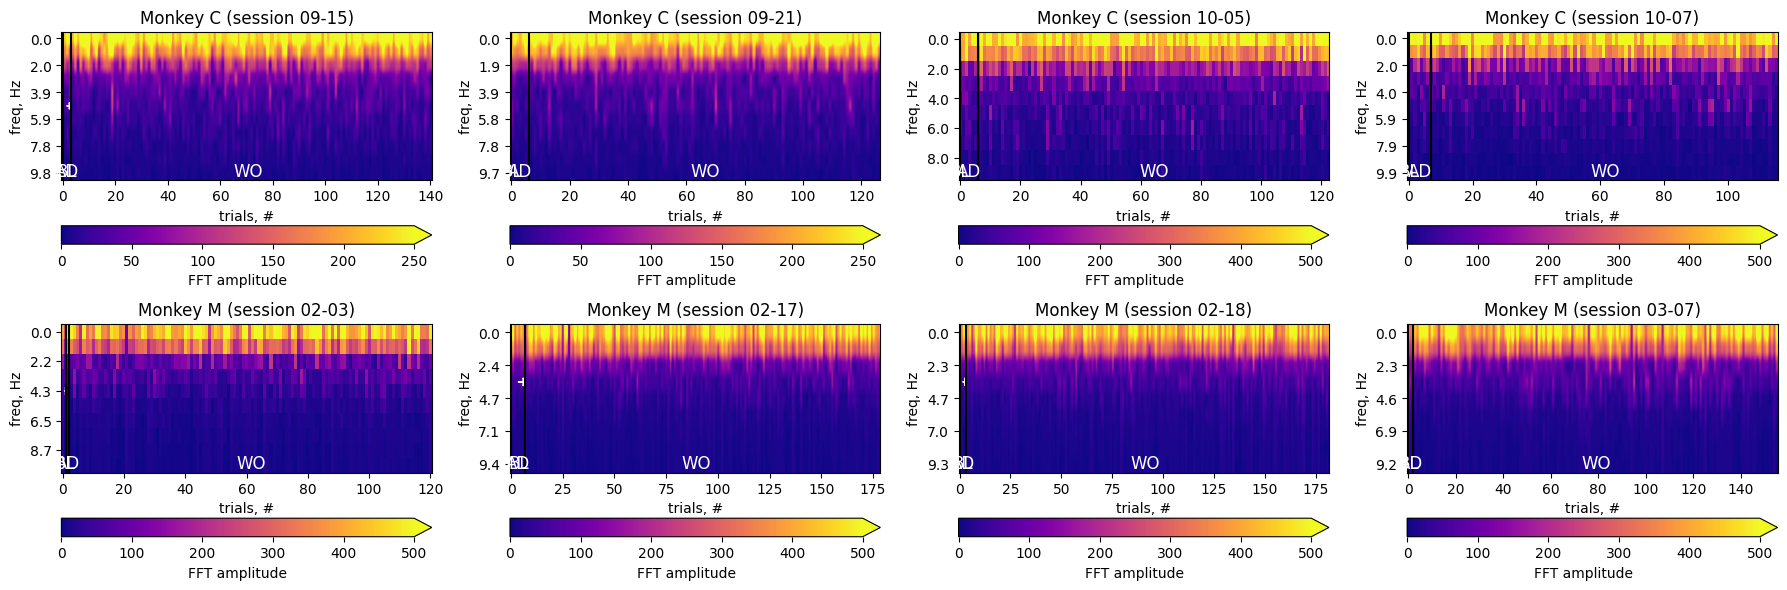

<IPython.core.display.Javascript object>

In [ ]:
fig, axes = plt.subplots(2,4,figsize=(18,6))

for j, (m, exps, peak_fr) in enumerate(zip(['C','M'],[experiments[:4],experiments[4:]],[5,4])):
    for i,spike_data_dir in enumerate(exps):
        vmax = 250 if (j==0) & (i<2) else 500
        plot_fourier_last_sessions(axes[j,i], monkey=m, spike_data_dir=spike_data_dir, 
                                   vel=vel, epoch=epoch_names,
                                   plot='spectrum', peak_freq = peak_fr, vmax=vmax)
        
plt.tight_layout()
fig.savefig('./figs/Figure4_sup.pdf')

In [ ]:
data['Chewie_CO_FF_2016-10-07'].keys()

dict_keys(['test_M1_MUA_birnn_pred', 'test_M1_band_100f_4c_pred', 'test_M1_band_10f_2c_pred', 'test_M1_band_10f_2c_sample1_pred', 'test_M1_band_10f_2c_sample2_pred', 'test_M1_band_10f_2c_sample3_pred', 'test_M1_band_10f_2c_sample4_pred', 'test_M1_band_12f_2c_pred', 'test_M1_band_12f_2c_sample1_pred', 'test_M1_band_12f_2c_sample2_pred', 'test_M1_band_12f_2c_sample3_pred', 'test_M1_band_12f_2c_sample4_pred', 'test_M1_band_14f_2c_pred', 'test_M1_band_14f_2c_sample1_pred', 'test_M1_band_14f_2c_sample2_pred', 'test_M1_band_14f_2c_sample3_pred', 'test_M1_band_14f_2c_sample4_pred', 'test_M1_band_16f_2c_pred', 'test_M1_band_16f_2c_sample1_pred', 'test_M1_band_16f_2c_sample2_pred', 'test_M1_band_16f_2c_sample3_pred', 'test_M1_band_16f_2c_sample4_pred', 'test_M1_band_32f_2c_pred', 'test_M1_band_32f_2c_sample1_pred', 'test_M1_band_32f_2c_sample2_pred', 'test_M1_band_4f_2c_pred', 'test_M1_band_4f_2c_sample1_pred', 'test_M1_band_4f_2c_sample2_pred', 'test_M1_band_64f_2c_pred', 'test_M1_band_64f_2c_

<IPython.core.display.Javascript object>

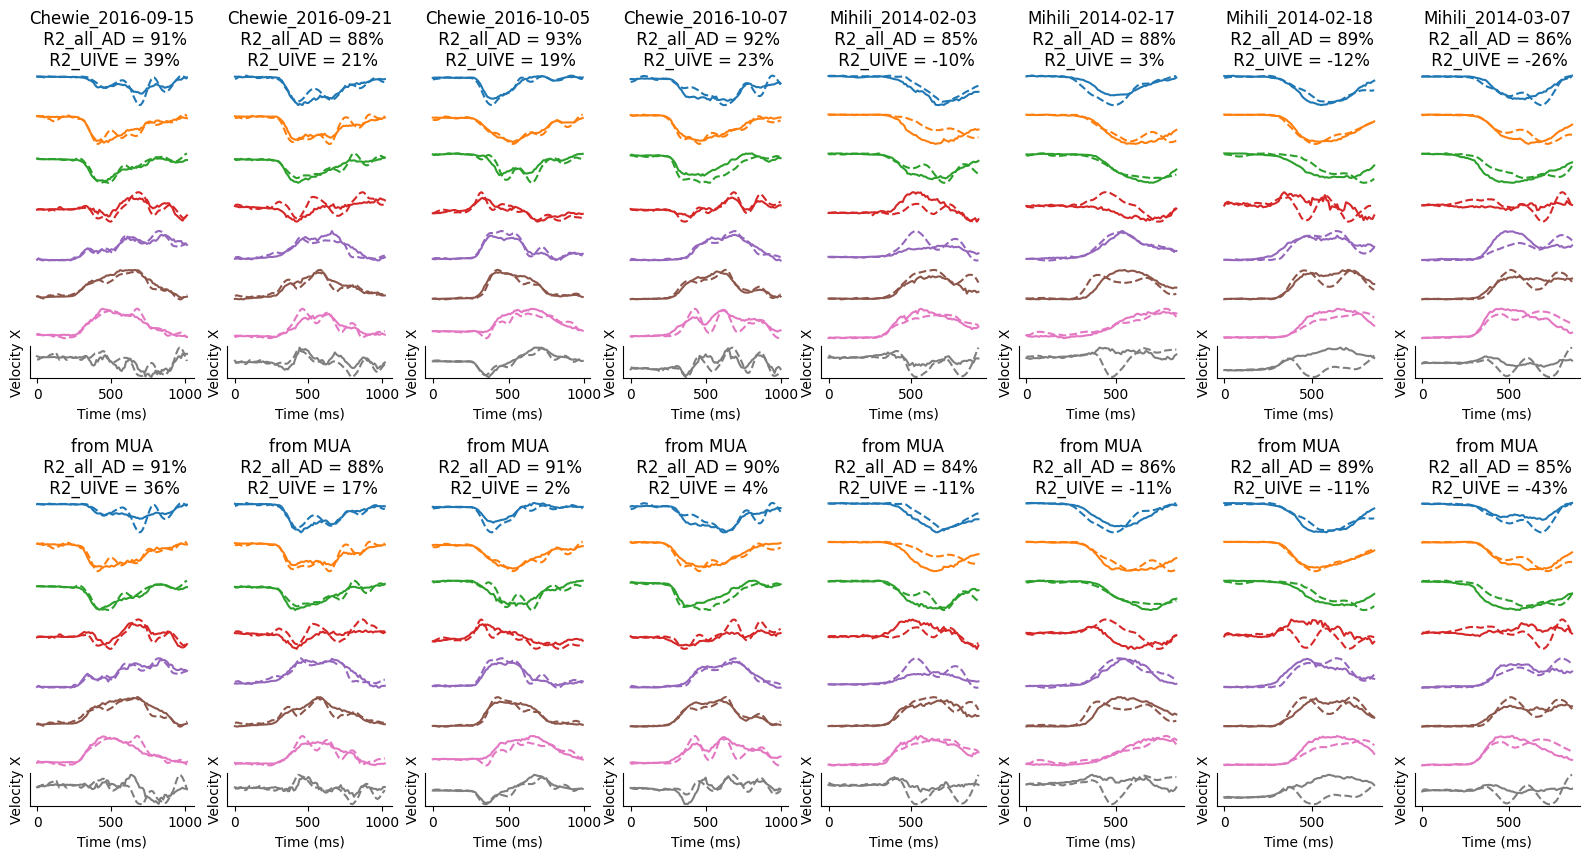

<IPython.core.display.Javascript object>

In [ ]:
fig, axes = plt.subplots(19,8,figsize=(8*2.5, (19)*.5))

component = 0

area = 'all'
key =f'test_{area}_birnn_pred'
for i, experiment in enumerate(experiments):

    # epoch_mask, epoch_name = (epoch[experiment]==0), 'BL'
    epoch_mask, epoch_name = (epoch[experiment]==1), 'AD'
    # epoch_mask, epoch_name = (epoch[experiment]==2), 'WO'

    title = experiment.split('_CO_FF')
    title = title[0] + title[1]

    plot_beh_pred(vel[experiment][epoch_mask], 
                data[experiment][key][epoch_mask], 
                dir_index[experiment][epoch_mask], 
                trials2plot[experiment][epoch_mask], 
                axes[:8,i], 
                area,
                epoch_name,
                component=1, 
                title=title)

for ax in axes[8:11].flatten():
    ax.axis("off")

area = 'all'
key =f'test_{area}_MUA_birnn_pred'
for i, experiment in enumerate(experiments):

    # epoch_mask, epoch_name = (epoch[experiment]==0), 'BL'
    epoch_mask, epoch_name = (epoch[experiment]==1), 'AD'
    # epoch_mask, epoch_name = (epoch[experiment]==2), 'WO'

    title = experiment.split('_CO_FF')
    title = title[0] + title[1]

    plot_beh_pred(vel[experiment][epoch_mask], 
                data[experiment][key][epoch_mask], 
                dir_index[experiment][epoch_mask], 
                trials2plot[experiment][epoch_mask], 
                axes[(8+3):,i], 
                area,
                epoch_name,
                component=1, 
                title='from MUA')

# plot fourier of predictions

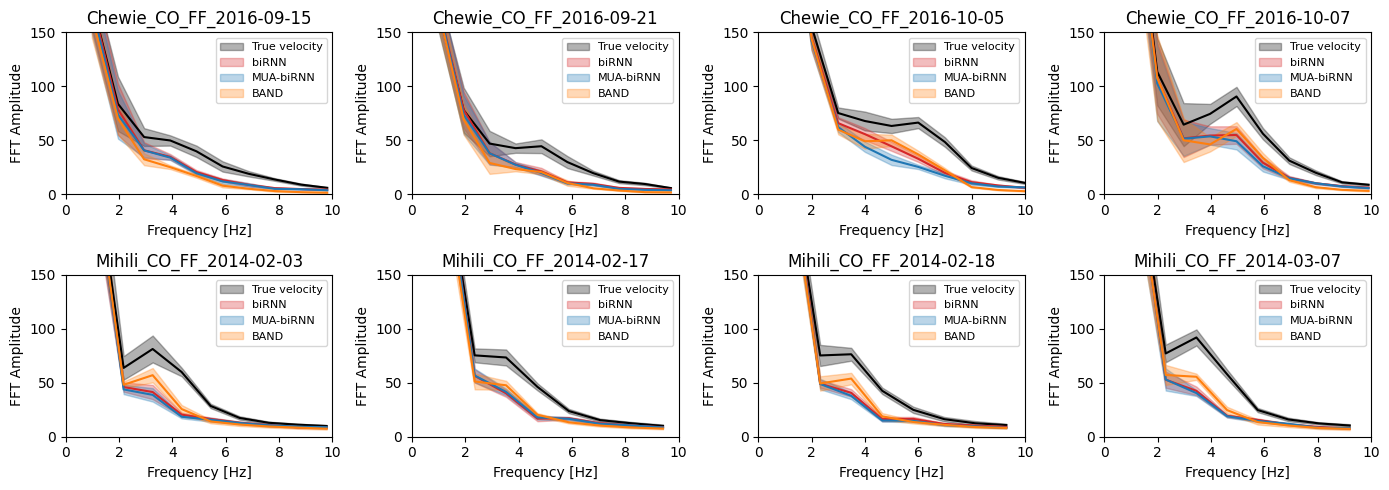

<IPython.core.display.Javascript object>

In [26]:

fig, axes = plt.subplots(2,4,figsize=(14,5))

dt = 0.01

def plot_fourier_AD(ax, V, label, color='k'):
    
    SR = []
    for _ in range(100):

        idxs = np.random.choice(V.shape[0], V.shape[0], replace=True)
        for c in [0,1]:

            x = V[idxs][...,c]

            xf = fft(x)  # Compute Fourier transform of x
            Sxx_all = np.sqrt((xf * xf.conj()).real) #2 * dt**2 / T * (xf * xf.conj())  # Compute spectrum

            Sxx = np.mean(Sxx_all, axis=0)  # trial average per epoch

            faxis = fftfreq(len(Sxx)) / dt  # Construct frequency axis

            SR.append(Sxx)

    SR = np.asarray(SR)

    mask = (faxis > 0) & (faxis <= 10)
    ax.plot(
        faxis[mask],
        SR.mean(0)[mask],color=color)
    
    ax.fill_between(
        faxis[mask],
        SR.mean(0)[mask] - SR.std(0)[mask],
        SR.mean(0)[mask] + SR.std(0)[mask],
        alpha=0.3, color=color, label=label
    )
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('FFT Amplitude')
    ax.set_ylim([0,150])
    ax.set_xlim([0,10])

for ax, exp in zip(axes.flatten(), experiments):
    plot_fourier_AD(ax, vel[exp][epoch[exp]==1], 'True velocity',color='k')
    plot_fourier_AD(ax, data[exp][f'test_all_birnn_pred'][epoch[exp]==1], 'biRNN',color='C3')
    plot_fourier_AD(ax, data[exp][f'test_all_MUA_birnn_pred'][epoch[exp]==1], 'MUA-biRNN',color='C0')
    plot_fourier_AD(ax, data[exp][f'test_all_band_pred'][epoch[exp]==1], 'BAND',color='C1')
    ax.legend(fontsize=8)
    ax.set_title(exp)
plt.tight_layout()

In [27]:
# mse_cebra = np.mean((data[f'test_{area}_cebra_pred'] - vel) ** 2,-1).mean(-1)
# mse_band = np.mean((data[f'test_{area}_band_pred'] - vel) ** 2,-1).mean(-1)
# plt.figure(figsize=(3,3))
# for e, en in enumerate(['BL','AD','WO']):
#     mask = epoch==e
#     plt.scatter(mse_cebra[mask], mse_band[mask],s=3,label=en)
# plt.legend()
# plt.xlim([0,50])
# plt.ylim([0,50])
# plt.plot([0,50],[0,50],'k--')
# plt.xlabel('CEBRA MSE')
# plt.ylabel('BAND MSE')
# plt.title(path.split('/')[-1].split('.')[0])

<IPython.core.display.Javascript object>

In [28]:
# mask = (mse_band<20) & (mse_cebra<mse_band) & (epoch == 1)

# fig, axes = plt.subplots(1,sum(mask),figsize=(sum(mask)*5, 3),sharey=True)
# for i,m in enumerate(np.where(mask)[0]):
#     axes[i].plot(vel[m,:,0].T,label='True')
#     axes[i].plot(data[f'test_{area}_cebra_pred'][m,:,0].T,label='CEBRA')
#     axes[i].plot(data[f'test_{area}_band_pred'][m,:,0].T,label='BAND')
#     # axes[i].plot(data[f'test_{area}_birnn_pred'][m,:,0].T,label='biRNN')
#     axes[i].legend()
#     axes[i].set_xlabel('Time (bins)')
#     axes[i].set_ylabel('Velocity X')

<IPython.core.display.Javascript object>

KeyError: 'test_all_birnn_pred'

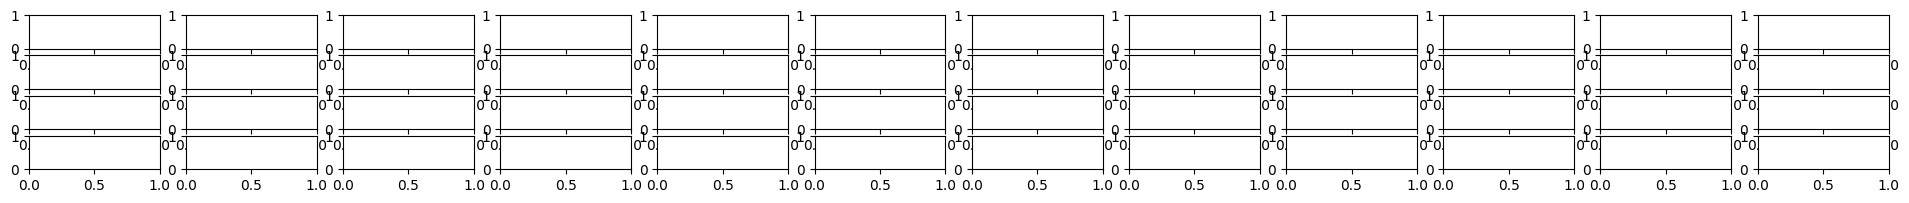

<IPython.core.display.Javascript object>

In [36]:
def plot_beh_pred(vel, pred_vel, dir_index, t2p, axes, area, epoch_name, select = None, component=0,title=""):
    '''
    Plot hand velocity and predicted hand velocity for each direction
    '''
    BIN_SIZE = 10 # ms
    time = np.arange(vel.shape[1]) * BIN_SIZE

    for v, ls in zip([vel, pred_vel], ["--", "solid"]):
        for t in range(0, vel.shape[0]):
            if t2p[t]:
                d = dir_index[t]
                if select is None:
                    d_id = d
                else:
                    if d in select:
                        d_id = np.where(select == d)[0][0]
                    else: 
                        d_id = None
                if d_id is not None:
                    axes[d_id].plot(
                        time,
                        v[t, :, component],
                        color=f"C{d}",
                        alpha=1,
                        ls=ls,
                    )
    for d in range(len(axes)):
        axes[d].axvline(0,c='k')

    for ax in axes[:-1]:
        ax.axis("off")
    axes[-1].spines['top'].set_visible(False)
    axes[-1].spines['right'].set_visible(False)
    axes[-1].set_yticks([])
    axes[-1].set_xlabel("Time (ms)")
    component_names = ['Velocity X', 'Velocity Y']
    axes[-1].set_ylabel(component_names[component])
    axes[0].text(0,0,'Go Cue',rotation=90,va='top',ha='right')

    R2_iso_vel = r2_score(pred_vel,vel)
    if component == 0:
        axes[0].set_title(f'{title}: R2 = {R2_iso_vel*100:.0f}%',loc='center')
        

fig, axes = plt.subplots(4,12,figsize=(12*2, 4*.5))

# epoch_mask, epoch_name = (epoch==0), 'BL'
epoch_mask, epoch_name = (epoch==1), 'AD'
# epoch_mask, epoch_name = (epoch==epoch), 'all'
component = 0

area = 'all'
for i, (key, title) in enumerate(zip([f'test_{area}_birnn_pred','test_all_avg_per_epoch_pred',
                                      f'test_{area}_lfads_pred',f'test_{area}_band_pred',
                                      f'test_{area}_cebra_pred',f'test_{area}_psid_pred'],
                                  ['biRNN decoder', 'Avg Vel per epoch',
                                   'LFADS', 'BAND',
                                   'CEBRA',"PSID"])):
    for j in [0,1]:
        # dir_index[epoch_mask].shape, trials2plot[epoch_mask].shape)
        plot_beh_pred(vel[experiment][epoch_mask], 
                    data[key][epoch_mask], 
                    dir_index[epoch_mask], 
                    trials2plot[epoch_mask], 
                    axes[:,2*i+j], 
                    area,
                    epoch_name,
                    select = np.array([0,2,5,7]),
                    component=j, 
                    title=title)
    

plt.subplots_adjust(wspace=0.5)
fig.savefig("figs/Figure4.svg")

KeyError: False

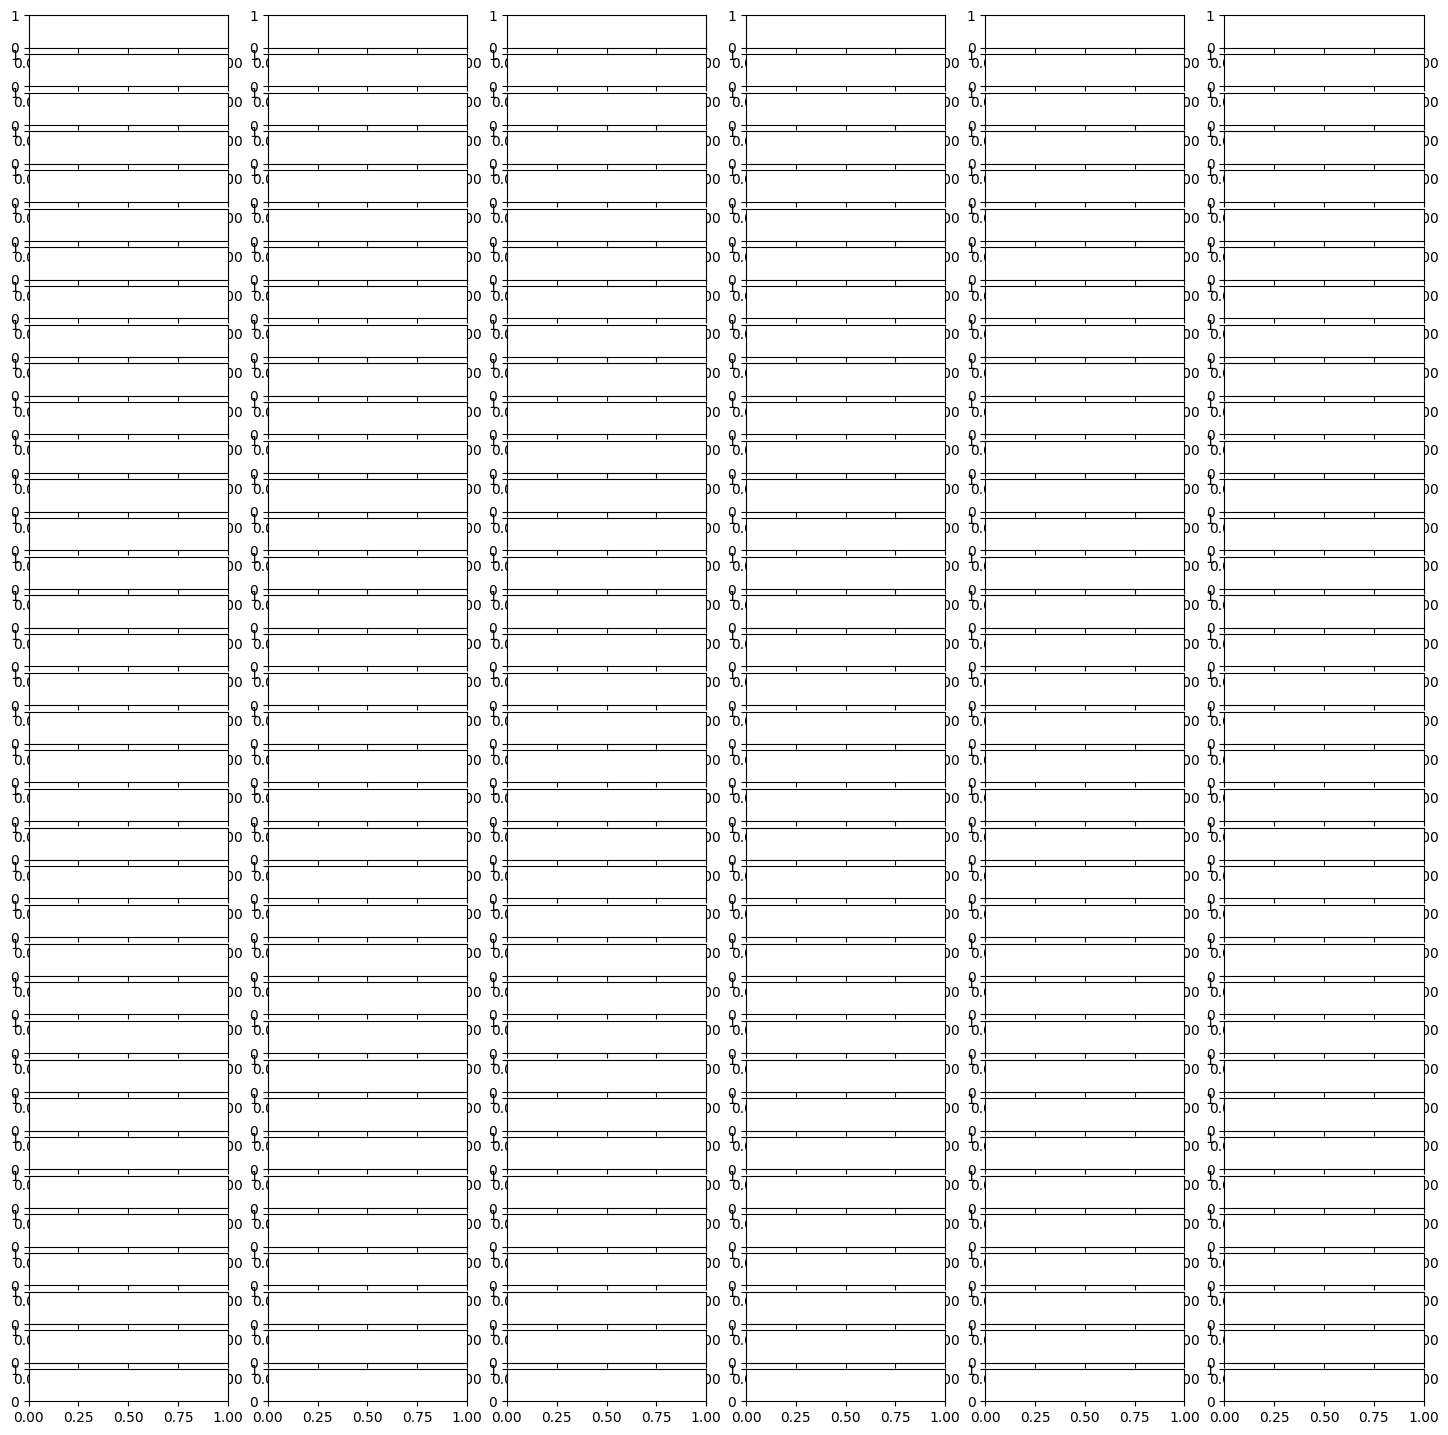

<IPython.core.display.Javascript object>

In [30]:
skip = 4
fig, axes = plt.subplots((8+skip)*3,6,figsize=(6*3, (8+skip)*.5*3))

# epoch_mask, epoch_name = (epoch==0), 'BL'
epoch_mask, epoch_name = (epoch==1), 'AD'
# epoch_mask, epoch_name = (epoch==epoch), 'all'
component = 0

# area = 'all'

import matplotlib.patches as patches
for j, area in enumerate(['all','M1','PMd']):
    model_keys = [f'test_{area}_birnn_pred','test_all_avg_per_epoch_pred',
                    f'test_{area}_lfads_pred',f'test_{area}_band_pred',
                    f'test_{area}_cebra_pred',f'test_{area}_psid_pred']
    for i, (key, title) in enumerate(zip(model_keys,
                                    ['biRNN decoder', 'Avg Vel per epoch',
                                    'LFADS', 'BAND',
                                    'CEBRA',"PSID"])):

        plot_beh_pred(vel[epoch_mask], 
                    data[key][epoch_mask], 
                    dir_index[epoch_mask], 
                    trials2plot[epoch_mask], 
                    axes[j*(8+skip)+skip:(j+1)*(8+skip),i], 
                    area,
                    epoch_name,
                    component=0, 
                    title=title)
        for k in range(skip):
            axes[j*(8+skip)+k,i].axis("off")
    if area=='all':
        area_title = 'PMd + M1'
    else:
        area_title = area
    axes[j*(8+skip)+skip-1,0].set_title(area_title)

fig.savefig("figs/Figure4_supplement.pdf")

[0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0]
[0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0]
[1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0]
[0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0]
[0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0]
[0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0]


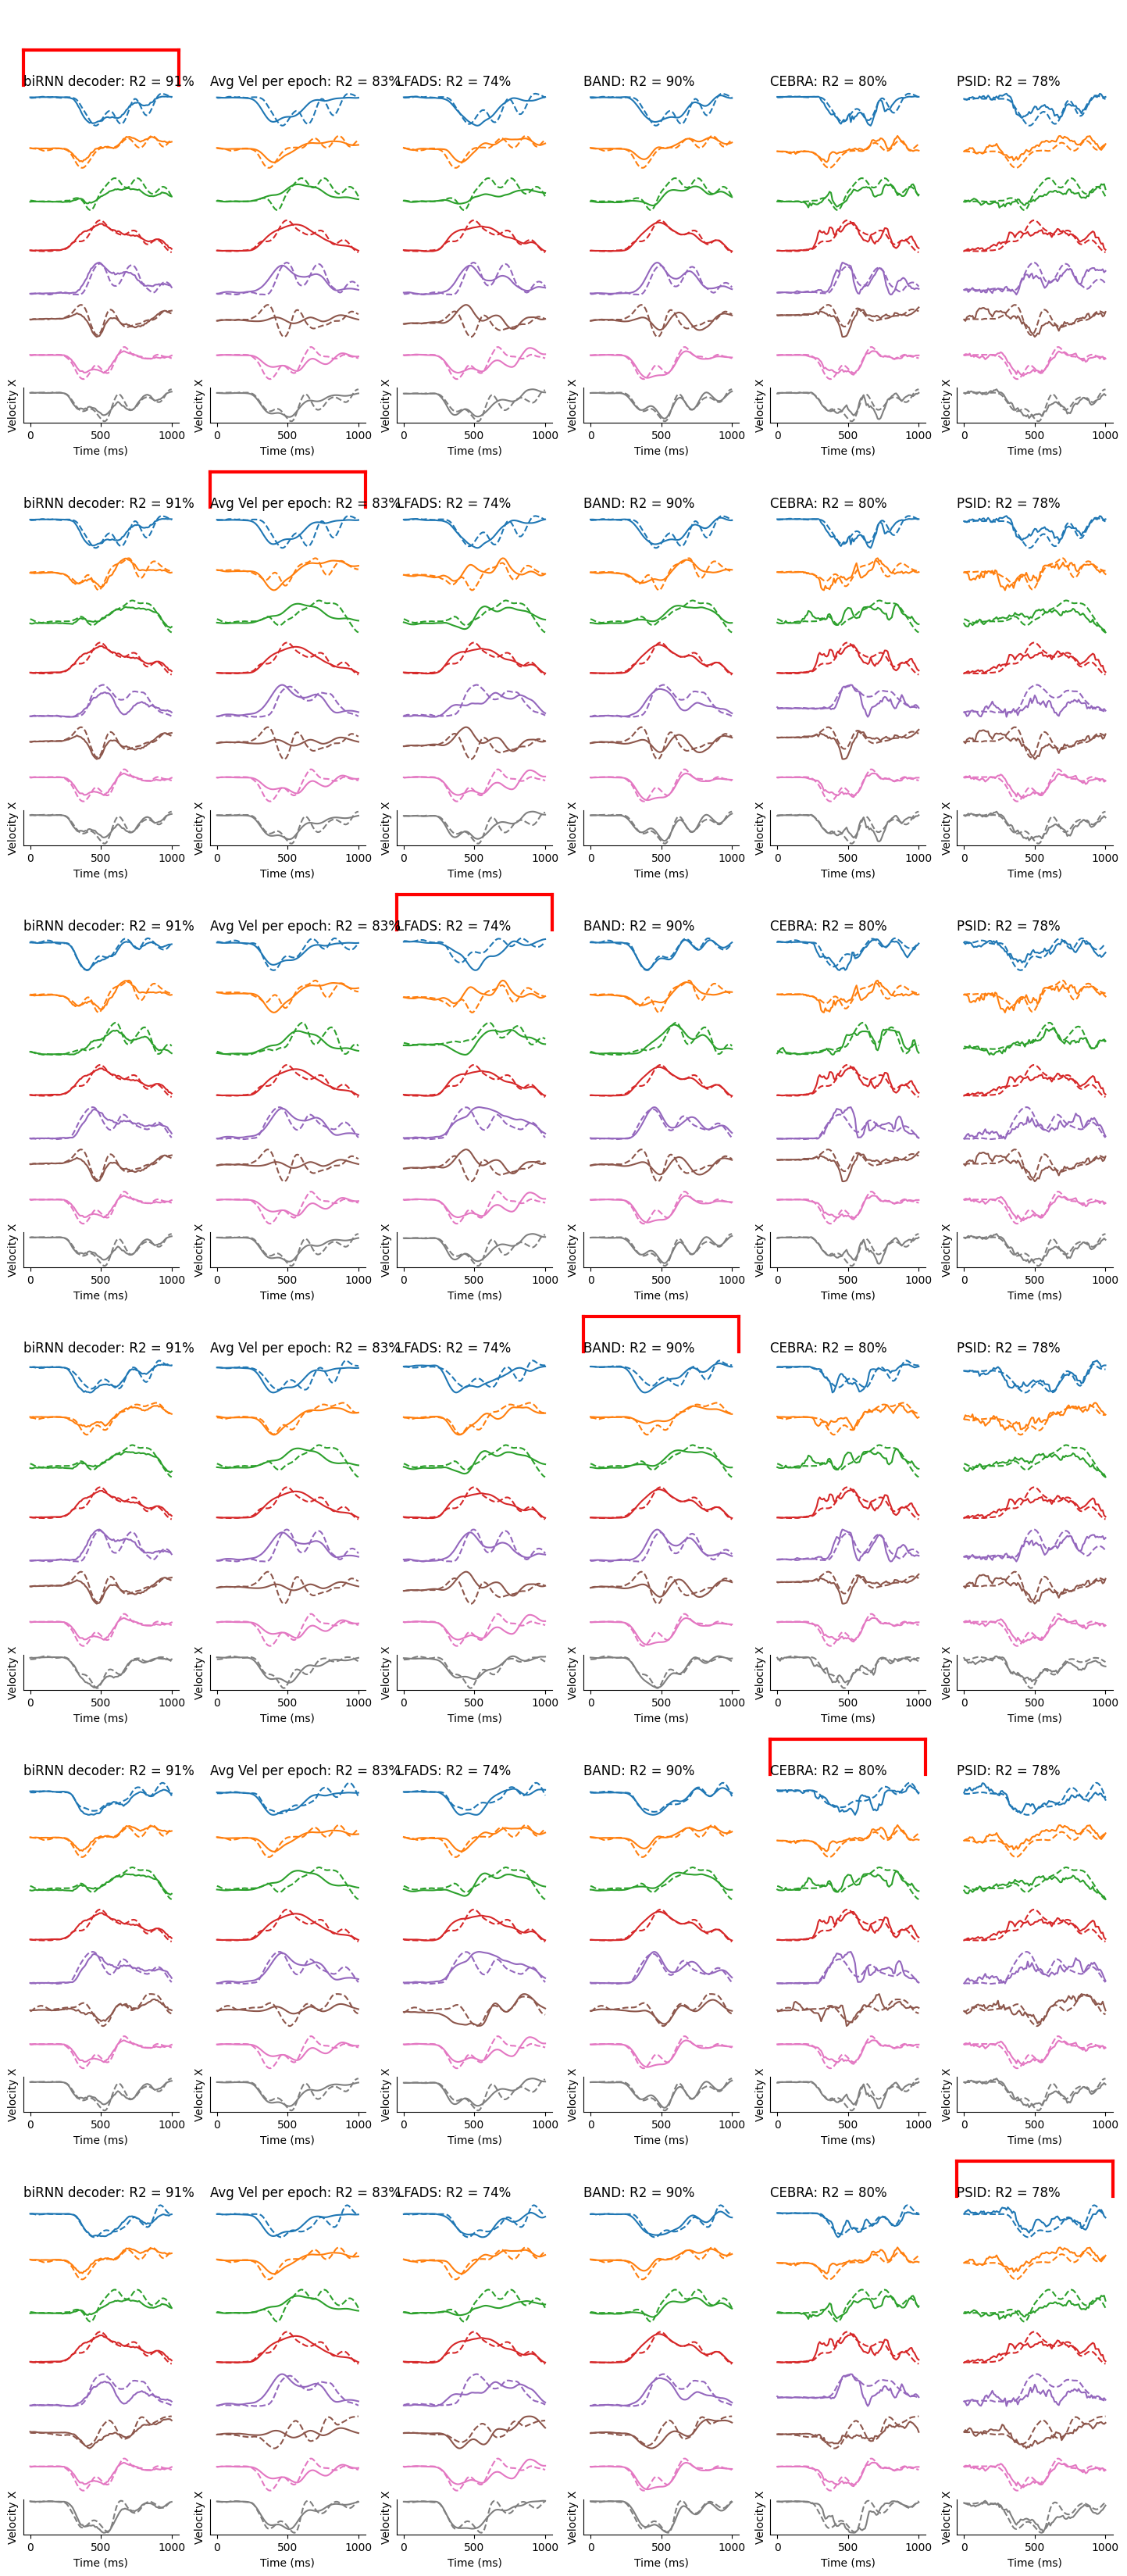

<IPython.core.display.Javascript object>

In [30]:
fig, axes = plt.subplots((8+2)*6,6,figsize=(6*3, (8+2)*.7*6))

# epoch_mask, epoch_name = (epoch==0), 'BL'
epoch_mask, epoch_name = (epoch==1), 'AD'
# epoch_mask, epoch_name = (epoch==epoch), 'all'
component = 0

area = 'all'
model_keys = [f'test_{area}_birnn_pred','test_all_avg_per_epoch_pred',
                f'test_{area}_lfads_pred',f'test_{area}_band_pred',
                f'test_{area}_cebra_pred',f'test_{area}_psid_pred']

import matplotlib.patches as patches
for j,model_key in enumerate(model_keys):
    trials2plot = np.array([get_trials2plot(vel, data[model_key], dir_index, epoch, i) for i in range(3)]).sum(0)
    print(trials2plot[epoch_mask])
    for i, (key, title) in enumerate(zip(model_keys,
                                    ['biRNN decoder', 'Avg Vel per epoch',
                                    'LFADS', 'BAND',
                                    'CEBRA',"PSID"])):

        plot_beh_pred(vel[epoch_mask], 
                    data[key][epoch_mask], 
                    dir_index[epoch_mask], 
                    trials2plot[epoch_mask], 
                    axes[j*10+2:(j+1)*10,i], 
                    area,
                    epoch_name,
                    component=0, 
                    title=title)
        axes[j*10,i].axis("off")
        axes[j*10+1,i].axis("off")
    axes[j*10+1,j].axis("on")
    for edge in ['top','left','right']:
        axes[j*10+1,j].spines[edge].set_color('red')
        axes[j*10+1,j].spines[edge].set_linewidth(3)
    axes[j*10+1,j].set_xticks([])
    axes[j*10+1,j].set_yticks([])
    axes[j*10+1,j].spines['bottom'].set_linewidth(0)



In [31]:
# loop through epochs (x3)
# loop through areas (keeping all for Avg) (x3)
# loop through components (x2)

# 18 figures in total. Paper: AD and all 3 areas, X coordinate

<IPython.core.display.Javascript object>